In [2]:
data['robot'].keys()

dict_keys(['time_stamp', 'sim_step', 'wall_clock', 'j_pos', 'j_vel', 'c_pos', 'c_vel', 'c_quat', 'des_c_pos', 'des_c_quat', 'des_j_pos', 'des_j_vel', 'des_j_acc', 'gripper_width'])

In [23]:
from scipy.spatial.transform import Rotation as R
import numpy as np

# Define a small epsilon to handle numerical precision
_EPS4 = np.finfo(float).eps * 4.0


def quat2euler(quat):
    """
    Convert a quaternion or an array of quaternions to Euler angles.
    The Euler angles are returned in the order: roll (X), pitch (Y), yaw (Z).

    This function expects quaternions in the [w, x, y, z] format.

    Parameters:
    -----------
    quat : array_like
        Quaternion(s) to convert. Shape can be (4,) for a single quaternion
        or (..., 4) for multiple quaternions. The expected order is [w, x, y, z].

    Returns:
    --------
    euler : ndarray
        Euler angles in radians. Shape is (..., 3).
    """
    # Convert input to numpy array with float64 dtype
    quat = np.asarray(quat, dtype=np.float64)

    # Ensure the quaternion has the correct shape
    if quat.ndim == 1:
        quat = quat[np.newaxis, :]  # Convert to 2D array for consistency
    elif quat.ndim > 2 or quat.shape[-1] != 4:
        raise ValueError(f"Invalid quaternion shape {quat.shape}. Expected shape (..., 4).")

    # Create a Rotation object from quaternions
    rotation = R.from_quat(quat, scalar_first=True)

    # Convert to rotation matrices
    mat = rotation.as_matrix()  # Shape (..., 3, 3)

    # Compute cy = sqrt(mat[...,2,2]^2 + mat[...,1,2]^2)
    cy = np.sqrt(mat[..., 2, 2] ** 2 + mat[..., 1, 2] ** 2)

    # Determine where cy is significant to avoid division by zero
    condition = cy > _EPS4

    # Initialize Euler angles array
    if len(mat.shape) == 3:
        euler = np.empty((mat.shape[0], 3), dtype=np.float64)
    else:
        euler = np.empty(mat.shape[:-1] + (3,), dtype=np.float64)

    # Compute yaw (Z axis rotation)
    euler[..., 2] = np.where(
        condition,
        -np.arctan2(mat[..., 0, 1], mat[..., 0, 0]),
        -np.arctan2(-mat[..., 1, 0], mat[..., 1, 1]),
    )

    # Compute pitch (Y axis rotation)
    euler[..., 1] = -np.arctan2(mat[..., 0, 2], cy)

    # Compute roll (X axis rotation)
    euler[..., 0] = np.where(
        condition,
        -np.arctan2(mat[..., 1, 2], mat[..., 2, 2]),
        0.0  # Gimbal lock: roll is set to zero
    )

    # If the input was a single quaternion, return a 1D array
    if euler.shape[0] == 1:
        return euler[0]

    return euler



In [22]:

# extract relevant keys from the data dictionary
robot_des_j_pos = data['robot']['des_j_pos']
robot_j_pos = data['robot']['j_pos']
robot_gripper = np.expand_dims(data['robot']['gripper_width'], -1)

red_box_pos = data['red-box']['pos'][:-1, :2]
red_box_quat = np.tan(quat2euler(data['red-box']['quat'])[:-1])

green_box_pos = data['green-box']['pos'][:-1, :2]
green_box_quat = np.tan(quat2euler(data['green-box']['quat'])[:-1])

blue_box_pos = data['blue-box']['pos'][:-1, :2]
blue_box_quat = np.tan(quat2euler(data['blue-box']['quat'])[:-1])

# Combine the information to create the observation state
env_state = np.concatenate([
    red_box_pos,
    red_box_quat,
    green_box_pos,
    green_box_quat,
    blue_box_pos,
    blue_box_quat,
], axis=-1)

input_state = np.concatenate((robot_j_pos, robot_gripper), axis=-1)
vel_state = robot_des_j_pos[1:] - robot_des_j_pos[:-1]
action = np.concatenate((vel_state, robot_gripper[1:]), axis=-1)


(674, 3)
(674, 3)
(674, 3)


pybullet build time: Nov 28 2023 23:45:17


Final IK error (72 iterations):  8.7999017010123e-06
Final IK error (0 iterations):  8.7999017010123e-06


/home/ksrini/.pyenv/versions/miniconda3-latest/envs/lerobot/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/home/ksrini/.pyenv/versions/miniconda3-latest/envs/lerobot/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


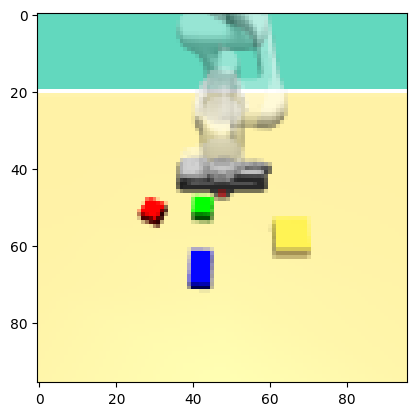

In [24]:
import matplotlib.pyplot as plt
import gymnasium as gym
import sys
sys.path.append("/home/ksrini/Temporary_D3IL/")
import gym_stacking
import numpy as np

env = gym.make("gym_stacking:gym_stacking/stacking-v0", render=False, action_type="absolute")
obs, _ = env.reset(context=data['context'])
plt.imshow(env.render())
plt.show()



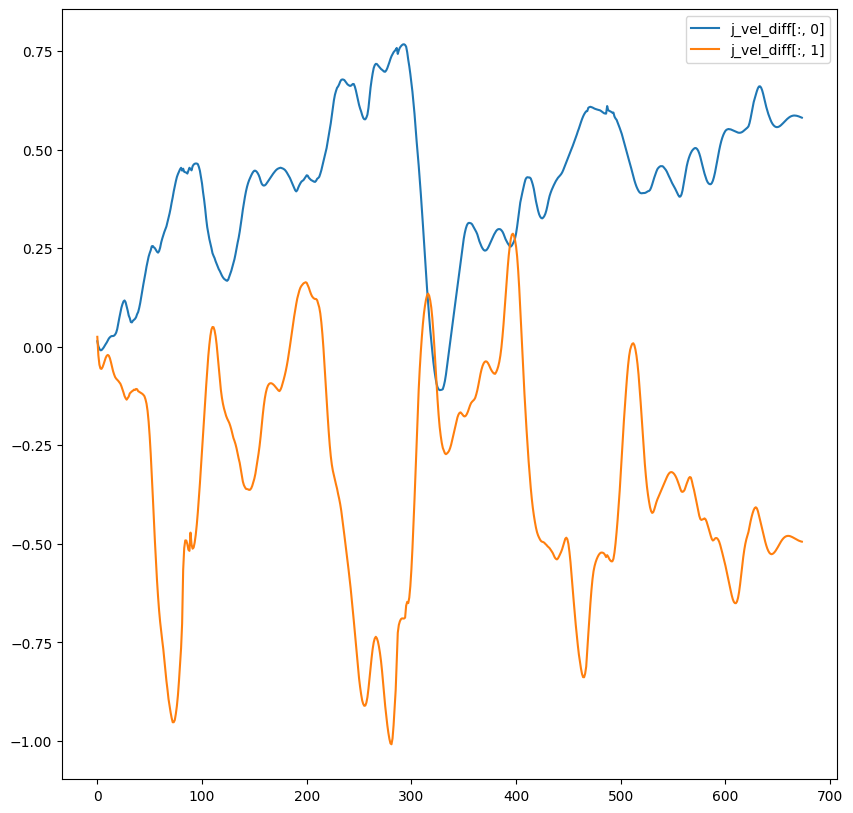

In [10]:
des_j_vel = data['robot']['des_j_pos'][:, 1:] - data['robot']['des_j_pos'][:, :-1]
j_vel = data['robot']['j_pos'][:, 1:] - data['robot']['j_pos'][:, :-1]
j_vel_true = data['robot']['j_vel'][:, :-1]
j_vel_diff = des_j_vel - j_vel_true

plt.figure(figsize=(10, 10))
plt.plot(j_vel_diff[:, 0], label='j_vel_diff[:, 0]')
plt.plot(j_vel_diff[:, 1], label='j_vel_diff[:, 1]')
plt.legend()
plt.show()


In [6]:
data['robot']['j_vel'][:2]

array([[-0.03515956,  0.00195794,  0.03480896,  0.00222681,  0.00757705,
        -0.00254904, -0.00375273],
       [-0.02259329,  0.04905571,  0.02387728,  0.04219096,  0.08043809,
        -0.03054364, -0.00924839]])

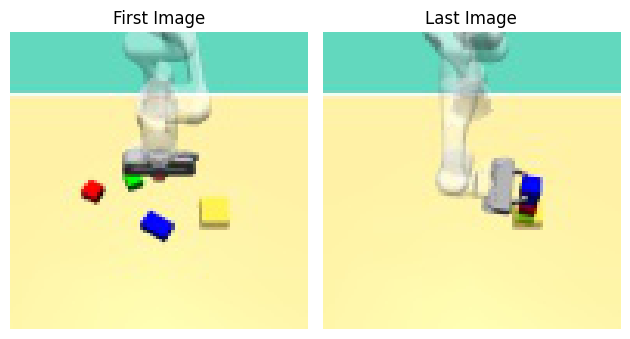

In [26]:
import matplotlib.pyplot as plt
from PIL import Image

from pathlib import Path

# Get the first and last image paths
image_dir = Path("/home/ksrini/Temporary_D3IL/environments/dataset/data/stacking/vision_data/images/bp-cam/env_0000_00/")
image_files = sorted(image_dir.glob("*.jpg"), key=lambda x: int(x.stem))
first_image_path = image_files[0]
last_image_path = image_files[-1]

# Load and display the first image
first_image = Image.open(first_image_path)
plt.subplot(1, 2, 1)
plt.imshow(first_image)
plt.axis('off')
plt.title("First Image")

# Load and display the last image
last_image = Image.open(last_image_path)
plt.subplot(1, 2, 2)
plt.imshow(last_image)
plt.axis('off')
plt.title("Last Image")

plt.tight_layout()
plt.show()


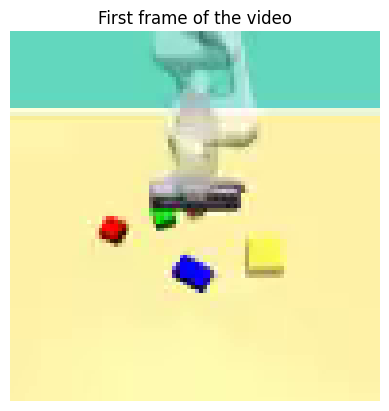

In [14]:
import cv2
from IPython.display import Video, display

video_path = "/home/ksrini/multi_task_experts/lerobot/data/krishpop/d3il_stacking/videos/observation.images.bp_cam_episode_000000.mp4"

# Display the video
display(Video(video_path, embed=True, width=640, height=480))

# Optional: If you want to show some frames from the video
cap = cv2.VideoCapture(video_path)

# Read and display the first frame
ret, frame = cap.read()
if ret:
    # plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("First frame of the video")
    plt.axis('off')
    plt.show()

# Release the video capture object
cap.release()


In [27]:
data['context']

([array([ 0.41195592, -0.24730536, 63.207466  ], dtype=float32),
  array([ 0.85169279,  0.        , -0.        ,  0.5240414 ])],
 [array([  0.36201504,  -0.09784092, -65.672775  ], dtype=float32),
  array([ 0.8402224 ,  0.        ,  0.        , -0.54224193])],
 [array([ 5.5194575e-01, -6.5401541e-03, -3.1276381e+01], dtype=float32),
  array([ 0.96298311,  0.        ,  0.        , -0.26956175])],
 [array([ 0.53971696,  0.16228664, 64.43401   ], dtype=float32),
  array([ 0.84603496,  0.        , -0.        ,  0.53312742])])

In [3]:
from hydra import compose, initialize_config_dir
from pathlib import Path
from lerobot.common.datasets.factory import make_dataset
import lerobot
# Create LeRobot dataset from ACT policy trainer class

lerobot_root = Path(lerobot.__path__[0])
config_path = lerobot_root / "configs"

with initialize_config_dir(config_dir=str(config_path)):
    hydra_cfg = compose(
       config_name="default.yaml", overrides=["policy=tdmpc2_d3il_stacking", "env=d3il_stacking", "dataset_root=data"]
    )

# Create dataset
orig_trainset2 = make_dataset(hydra_cfg, root=hydra_cfg.dataset_root, action_key="action_abs")

/tmp/ipykernel_288927/1353712290.py:10: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=str(config_path)):


In [10]:
item = orig_trainset[0]
item2 = orig_trainset2[0]
item['action_abs'] == item2['action']

tensor([True, True, True, True, True, True, True, True])

/home/ksrini/.pyenv/versions/miniconda3-latest/envs/lerobot/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.robot_state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.robot_state` for environment variables or `env.get_wrapper_attr('robot_state')` that will search the reminding wrappers.
  logger.warn(


True False


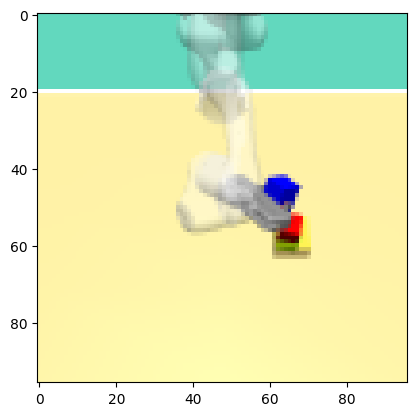

In [10]:
import matplotlib.pyplot as plt
import gymnasium as gym

import sys
if "/home/ksrini/Temporary_D3IL/" not in sys.path:
    sys.path.append("/home/ksrini/Temporary_D3IL/")
import pickle
import gym_stacking
import numpy as np


with open("/home/ksrini/Temporary_D3IL/environments/dataset/data/stacking/vision_data/state/env_0000_00.pkl", "rb") as f:
    data = pickle.load(f)

if "env" not in locals():
    env = gym.make("gym_stacking:gym_stacking/stacking-v0", render=False, action_type="delta")
env.action_type = "delta"
obs, _ = env.reset(random=False, context=data['context'])

# actions = np.concatenate([data['robot']["des_j_vel"], data['robot']["gripper_wid][:-1], data['robot']["gripper_width"][:, None][1:]], axis=-1)
actions = np.concatenate([data['robot']["des_j_pos"] - data['robot']["j_pos"], data['robot']["gripper_width"][:, None]], axis=-1)
# actions = np.concatenate([data['robot']["j_pos"], data['robot']["gripper_width"][:, None]], axis=-1)

pred_action, _, _ = env.robot_state()
pred_action = pred_action.astype(np.float32)

done = False
i = 0

while not done and i < len(actions):
    obs = np.concatenate((pred_action, obs))
    pred_action = actions[i]  # Use the pre-defined actions
    # pred_action[:7] = pred_action[:7] + obs[:7]
    
    obs, reward, terminated, truncated, info = env.step(pred_action)
    done = terminated or truncated
    i += 1

    if done:
        break

print(terminated, truncated)

plt.imshow(env.render())
plt.show()

In [12]:
from pathlib import Path

In [13]:
# Get sets of environment names from both directories
all_data_envs = set(x.name.split(".")[0] for x in Path("/home/ksrini/Temporary_D3IL/environments/dataset/data/stacking/all_data/").glob("env*"))
vision_data_envs = set(x.name for x in Path("/home/ksrini/Temporary_D3IL/environments/dataset/data/stacking/vision_data/images/bp-cam/").glob("env*"))

# Environments in vision_data but not in all_data
in_vision_not_all = vision_data_envs - all_data_envs

# Environments in all_data but not in vision_data
in_all_not_vision = all_data_envs - vision_data_envs

print("Environments in vision_data but not in all_data:")
print(sorted(in_vision_not_all, key=lambda x: int(x.split('_')[1])))
print("\nEnvironments in all_data but not in vision_data:")
print(sorted(in_all_not_vision, key=lambda x: int(x.split('_')[1])))

Environments in vision_data but not in all_data:
['env_0105_00', 'env_0274_00', 'env_0358_00', 'env_0403_00', 'env_0435_00', 'env_0541_00', 'env_0556_00', 'env_0574_00', 'env_0586_00', 'env_0614_00', 'env_0727_00', 'env_0999_00', 'env_1025_00', 'env_1027_00', 'env_1288_00', 'env_1357_00', 'env_1360_00', 'env_1406_00', 'env_1417_00']

Environments in all_data but not in vision_data:
['env_0155_00', 'env_0187_00', 'env_0243_00', 'env_0284_00', 'env_0487_00', 'env_0504_00', 'env_0788_00', 'env_0802_00', 'env_0820_00', 'env_0887_00', 'env_1038_00', 'env_1059_00', 'env_1102_00', 'env_1144_00', 'env_1179_00', 'env_1190_00', 'env_1220_00', 'env_1259_00', 'env_1276_00', 'env_1328_00']


In [14]:
vision_data_path = Path("/home/ksrini/Temporary_D3IL/environments/dataset/data/stacking/vision_data/state/")
env_data = list(vision_data_path.glob("env*"))

all_data_path = Path("/home/ksrini/Temporary_D3IL/environments/dataset/data/stacking/all_data/")
all_env_data = list(all_data_path.glob("env*"))
intersection = set([x.name for x in env_data]).intersection(set([x.name for x in all_env_data]))

for p in intersection:
    p = vision_data_path / p
    with open(p, "rb") as f:
        data1 = pickle.load(f)
    p2 = all_data_path / p
    with open(p2, "rb") as f:
        data2 = pickle.load(f)
    if not np.all([np.allclose(np.concatenate(c1), np.concatenate(c2)) for c1, c2 in zip(data1['context'], data2['context'])]):
        print(p)
    assert len(data1['robot']['des_j_pos']) == len(data2['robot']['des_j_pos'])


In [ ]:
from lerobot.common.datasets.push_dataset_to_hub.stacking_pkl_format import from_raw_to_lerobot_format
from pathlib import Path

raw_dir = Path("/home/ksrini/Temporary_D3IL/environments/dataset/data/stacking/vision_data")
videos_dir = None
video = False  
episodes = [0, 1, 2]
hf_dataset, episode_data_index, info = from_raw_to_lerobot_format(raw_dir, videos_dir, video=video, episodes=episodes)
print(hf_dataset)
print(episode_data_index)


# ep_dicts = load_from_raw(raw_dir, videos_dir, fps=33.33333333, video=video, episodes=episodes)

3it [00:00,  6.44it/s]


Dataset({
    features: ['observation.state', 'action', 'observation.images.bp_cam', 'observation.images.inhand_cam', 'episode_index', 'frame_index', 'timestamp', 'index'],
    num_rows: 1945
})
{'from': tensor([   0,  673, 1334]), 'to': tensor([ 673, 1334, 1945])}
